# Height Simulation

In [1]:
import torch
import pyro
import pyro.distributions as dist
from pyro.ops.indexing import Vindex
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.io import savemat

In [2]:
from cosmos.models.utils import pi_m_calc, pi_theta_calc
from cosmos.distributions import AffineBeta
from cosmos.utils.dataset import CoSMoSDataset

In [3]:
N = 15 # number of AOIs
D = 14 # AOI size
F = 500 # number of frames

In [4]:
# target locations
X, Y = np.meshgrid(np.arange(5)*D*2+2*D+(D-1)/2, np.arange(3)*D*2+2*D+(D-1)/2)

target = pd.DataFrame(data={"x": X.flatten(), "y": Y.flatten()}, index=np.arange(N))
target.index.name = "aoi"

drift = pd.DataFrame(data={"dx": 0., "dy": 0.}, index=np.arange(F))
drift.index.name = "frame"

In [5]:
class GaussianSpot():
    def __init__(self, target, drift, X, Y):
        # create meshgrid of DxD pixel positions
        i_pixel, j_pixel = torch.meshgrid(
            torch.arange(X), torch.arange(Y))
        self.ij_pixel = torch.stack((i_pixel, j_pixel), dim=-1).float()

        # drift locs for 2D gaussian spot
        self.target_locs = torch.tensor(
            drift[["dx", "dy"]].values.reshape(-1, 2)
            + target[["x", "y"]].values.reshape(-1, 1, 2)) \
            .float()

    # Ideal 2D gaussian spots
    def forward(self, height, width, x, y, n_idx, m_mask=None, f=None):
        if m_mask is not None:
            height = height.masked_fill(~m_mask, 0.)
        if f is not None:
            spot_locs = self.target_locs[n_idx, f] + torch.stack((x, y), dim=-1)
        else:
            spot_locs = self.target_locs[n_idx] + torch.stack((x, y), dim=-1)
        rv = dist.MultivariateNormal(
            spot_locs[..., None, None, :],
            scale_tril=torch.eye(2) * width[..., None, None, None, None])
        gaussian_spot = torch.exp(rv.log_prob(self.ij_pixel))  # N,F,D,D
        return (height[..., None, None] * gaussian_spot).sum(dim=(0,1))

In [6]:
loc = GaussianSpot(target, drift, 2*D*7-14, 2*D*5-14)

In [7]:
sim = "height"
heights = ["0300", "0500", "0750", "1000", "1500", "2000", "3000"]
pi_z = "15"
lamda_j = "15"
sigma = "0.2"

In [8]:
# simulation parameters
gain = torch.tensor([7.])
offset = torch.tensor([90.])
background = torch.tensor([150.])
pi = torch.tensor([1-float(pi_z)/100, float(pi_z)/100])
lamda = torch.tensor([1-float(lamda_j)/100, float(lamda_j)/100]) # 0.2 / AOI
pi_m = pi_m_calc(lamda, 1)
pi_theta = pi_theta_calc(pi, 2, 1)
w_mode = torch.tensor([1.4])
w_size = torch.tensor([100.])

size = torch.tensor([2., (((D+1) / (2*float(sigma))) ** 2 - 1)])
m_matrix = torch.tensor([[0, 0], [1, 0], [0, 1]]).T.reshape(2, 1, 1, 3)
theta_matrix = torch.tensor([[0, 0], [1, 0], [0, 1]]).T.reshape(2, 1, 1, 3)

for h in heights:
    pyro.set_rng_seed(0)

    with pyro.plate("F", F, dim=-1):
        with pyro.plate("N", N, dim=-2):
            theta = pyro.sample("theta", dist.Categorical(pi_theta))
            theta_mask = Vindex(theta_matrix)[..., theta]
            m_mask = Vindex(m_matrix)[..., theta]
            with pyro.plate("K", 2, dim=-3):
                m_mask = pyro.sample("m", dist.Categorical(Vindex(pi_m)[m_mask]))
                height = pyro.sample("height", dist.Gamma(float(h) / gain, 1 / gain))
                width = pyro.sample("width", AffineBeta(w_mode, w_size, 0.75, 2.25))
                x = pyro.sample("x", AffineBeta(0, size[theta_mask], -(D+1)/2, (D+1)/2))
                y = pyro.sample("y", AffineBeta(0, size[theta_mask], -(D+1)/2, (D+1)/2))

            height = height.masked_fill(m_mask==0, 0.)
            locs = loc.forward(height, width, x, y, torch.arange(N)) + background

        #image = locs + junks + background
        data = pyro.sample("data", dist.Gamma(locs / gain, 1 / gain).to_event(2))
    
    data = data.long() + offset
    labels = np.zeros((N, F), dtype=[("aoi", int), ("frame", int), ("z", bool), ("theta", bool, (2,))])
    labels["aoi"] = np.arange(N).reshape(-1, 1)
    labels["frame"] = np.arange(F)
    labels["z"] = theta.squeeze() > 0
    labels["theta"] = theta_mask.permute(1, 2, 0)
    
    cosmos_data = torch.zeros(N, F, D, D)
    cosmos_target = target.copy()
    cosmos_drift = drift.copy()
    
    with pyro.plate("F", F, dim=-1):
        with pyro.plate("N", N, dim=-2):
            theta = 0
            theta_mask = Vindex(theta_matrix)[..., theta]
            m_mask = Vindex(m_matrix)[..., theta]
            with pyro.plate("K", 2, dim=-3):
                m_mask = pyro.sample("m", dist.Categorical(Vindex(pi_m)[m_mask]))
                height = pyro.sample("height", dist.Gamma(float(h) / gain, 1 / gain))
                width = pyro.sample("width", AffineBeta(w_mode, w_size, 0.75, 2.25))
                x = pyro.sample("x", AffineBeta(0, size[theta_mask], -(D+1)/2, (D+1)/2))
                y = pyro.sample("y", AffineBeta(0, size[theta_mask], -(D+1)/2, (D+1)/2))

            height = height.masked_fill(m_mask==0, 0.)
            control_locs = loc.forward(height, width, x, y, torch.arange(N)) + background

        #image = locs + junks + background
        control_data = pyro.sample("data", dist.Gamma(control_locs / gain, 1 / gain).to_event(2))
    
    
    control_data = control_data.long() + offset

    
    control_cosmos_data = torch.zeros(N, F, D, D)

    for i, frame in enumerate(drift.index):
        for j, aoi in enumerate(target.index):
            top_x = int((target.at[aoi, "x"] - (D-1) * 0.5) // 1
                        + drift.at[frame, "dx"] // 1)
            left_y = int((target.at[aoi, "y"] - (D-1) * 0.5) // 1
                         + drift.at[frame, "dy"] // 1)
            cosmos_data[j, i] = data[i, top_x:top_x+D, left_y:left_y+D]
            control_cosmos_data[j, i] = control_data[i, top_x:top_x+D, left_y:left_y+D]
            #print(top_x, left_y)

    for j, aoi in enumerate(target.index):
        cosmos_target.at[aoi, "x"] = target.at[aoi, "x"] - int((target.at[aoi, "x"] - (D-1) * 0.5) // 1)
        cosmos_target.at[aoi, "y"] = target.at[aoi, "y"] - int((target.at[aoi, "y"] - (D-1) * 0.5) // 1)
    
    dataset = CoSMoSDataset(cosmos_data, cosmos_target, cosmos_drift,
                            dtype="test", device=torch.device("cpu"), labels=labels)
    path_data = "/shared/centaur/data/height_data/h{}pi{}lamda{}".format(h, pi_z, lamda_j)
    dataset.save(path_data)
    savemat(
        os.path.join(path_data, "h{}pi{}lamda{}.mat".format(h, pi_z, lamda_j)),
        {"data": data.numpy(), "binary": labels["z"], "aoiinfo": loc.target_locs.numpy()})

    control_dataset = CoSMoSDataset(control_cosmos_data, cosmos_target, cosmos_drift,
                                    dtype="control", device=torch.device("cpu"))
    control_dataset.save(path_data)
    savemat(
        os.path.join(path_data, "control_h{}pi{}lamda{}.mat".format(h, pi_z, lamda_j)),
        {"data": control_data.numpy(), "aoiinfo": loc.target_locs.numpy()})

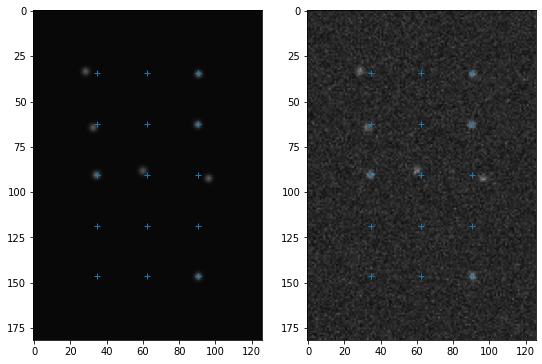

In [9]:
frame = 15

plt.figure(figsize=(9,13/2))
plt.subplot(121)
plt.imshow(locs[frame].data, cmap="gray", vmin=data.min(), vmax=data.max())
plt.plot(Y, X, "C0+")

plt.subplot(122)
plt.imshow(data[frame].data, cmap="gray", vmin=data.min(), vmax=data.max())
plt.plot(Y, X, "C0+")
plt.show()

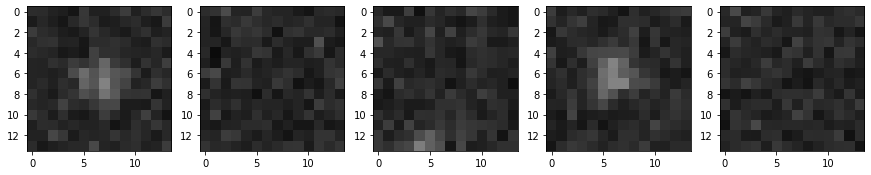

In [10]:
plt.figure(figsize=(15,3))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(cosmos_data[0,i].data, vmin=data.min(), vmax=data.max(), cmap="gray")
plt.show()

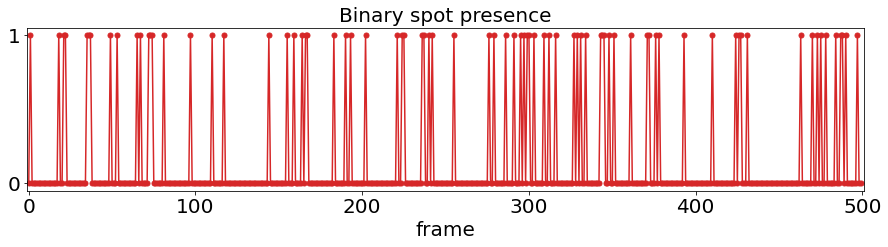

In [11]:
plt.figure(figsize=(15,3))
plt.plot(labels["z"][1], marker="o", ms=5, color="C3")
#plt.ylim(0,1)
plt.xlim(-1,501)
plt.xlabel(r"frame", fontsize=20)
#plt.ylabel(r"spot presence", fontsize=20)
plt.title(r"Binary spot presence", fontsize=20)
plt.gca().axes.get_yaxis().set_ticks(np.arange(2)*1)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

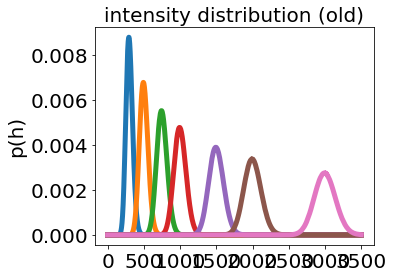

In [12]:
x = torch.arange(0,3500.,0.1)

plt.figure(figsize=(5,4))
for h in heights:
    d = dist.Gamma(float(h) / gain, 1 / gain)
    plt.plot(x, torch.exp(d.log_prob(x)).cpu(), lw=5)

#plt.gca().axes.get_xaxis().set_ticks([100])
#plt.gca().axes.get_yaxis().set_ticks([])
#plt.xticks(size=30)
plt.title("intensity distribution", fontsize=20)
plt.ylabel("p(h)", fontsize=20)
#plt.ylim(0, 0.003)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

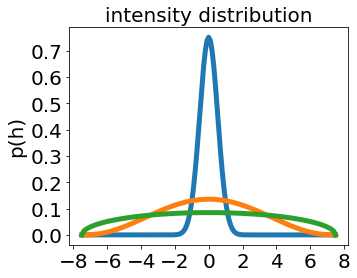

In [24]:
x = torch.arange(-10.,10.,0.1)

plt.figure(figsize=(5,4))

d1 = AffineBeta(0, 200., -7.5, 7.5)
d2 = AffineBeta(0, 7., -7.5, 7.5)
d3 = AffineBeta(0, 3., -7.5, 7.5)
plt.plot(x, torch.exp(d1.log_prob(x)).cpu(), lw=5)
plt.plot(x, torch.exp(d2.log_prob(x)).cpu(), lw=5)
plt.plot(x, torch.exp(d3.log_prob(x)).cpu(), lw=5)

#plt.gca().axes.get_xaxis().set_ticks([100])
#plt.gca().axes.get_yaxis().set_ticks([])
#plt.xticks(size=30)
plt.title("intensity distribution", fontsize=20)
plt.ylabel("p(h)", fontsize=20)
#plt.ylim(0, 0.003)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

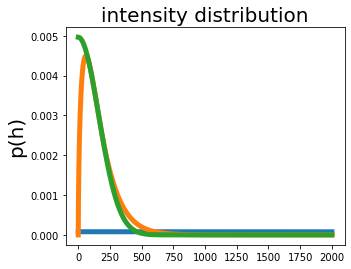

In [109]:
x = torch.arange(0,2000.,0.1)
y = torch.arange(0,20000.,0.1)

plt.figure(figsize=(5,4))

def log_accept(x):
    return torch.where(x > 90, torch.tensor(0.), torch.tensor(-40.))
d = dist.Rejector(dist.Gamma(90/7, 1/7), log_accept, 0)

d1 = dist.HalfNormal(10000.)
d2 = dist.Gamma(np.sqrt(150*7/0.0406)/100, 1/100)
#d3 = dist.Gamma(190/7, 1/7)
d3 = dist.HalfNormal(np.sqrt(150*7/0.0406))
plt.plot(x, torch.exp(d1.log_prob(x)).cpu(), lw=5)
plt.plot(x, torch.exp(d2.log_prob(x)).cpu(), lw=5)
plt.plot(x, torch.exp(d3.log_prob(x)).cpu(), lw=5)

#plt.gca().axes.get_xaxis().set_ticks([100])
#plt.gca().axes.get_yaxis().set_ticks([])
#plt.xticks(size=30)
plt.title("intensity distribution", fontsize=20)
plt.ylabel("p(h)", fontsize=20)
#plt.ylim(0, 0.001)
#plt.xticks(size=20)
#plt.yticks(size=20)
plt.show()

In [74]:
np.sqrt(150 * 7)

32.4037034920393

In [61]:
dist.Gamma(90/7, 1/7).variance.sqrt()

tensor(25.0998)

In [98]:
np.sqrt(0.0406)

0.20149441679609884

In [102]:
500*0.0406

20.299999999999997

In [139]:
d = AffineBeta(0, 100, -7.5, 7.5)

In [140]:
x = (d.log_prob(torch.arange(-2,2,0.1).float())
 + d.log_prob(torch.arange(-2,2,0.1).reshape(-1,1).float())).exp()

In [141]:
x

tensor([[0.0002, 0.0003, 0.0004,  ..., 0.0006, 0.0004, 0.0003],
        [0.0003, 0.0004, 0.0006,  ..., 0.0008, 0.0006, 0.0004],
        [0.0004, 0.0006, 0.0008,  ..., 0.0012, 0.0008, 0.0006],
        ...,
        [0.0006, 0.0008, 0.0012,  ..., 0.0016, 0.0012, 0.0008],
        [0.0004, 0.0006, 0.0008,  ..., 0.0012, 0.0008, 0.0006],
        [0.0003, 0.0004, 0.0006,  ..., 0.0008, 0.0006, 0.0004]])

In [142]:
D_range = torch.arange(14, dtype=torch.float)
i_pixel, j_pixel = torch.meshgrid(D_range, D_range)
ij_pixel = torch.stack((i_pixel, j_pixel), dim=-1)

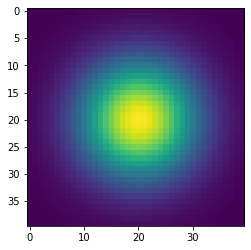

In [143]:
plt.imshow(x)

In [127]:
torch.arange(1,3,0.1)

tensor([1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000, 1.8000,
        1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000, 2.7000,
        2.8000, 2.9000])